<a href="https://colab.research.google.com/github/muntakim1/BanglaTextGeneration/blob/master/Covid_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisits

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow-gpu==2.4.
!pip install livelossplot

In [ ]:
mkdir /root/.kaggle/

In [ ]:
!cp ./kaggle.json /root/.kaggle/

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

100% 777M/778M [00:02<00:00, 240MB/s]
100% 778M/778M [00:02<00:00, 282MB/s]


In [ ]:
!unzip /content/covid19-radiography-database.zip

# Data Processing

In [ ]:
!mkdir train
!mkdir train/COVID
!mkdir train/Normal
!cp -r /content/COVID-19_Radiography_Dataset/COVID/images/*.png /content/train/COVID
!for FILE in `find /content/COVID-19_Radiography_Dataset/Normal/images/*.png ! -type d  | head -n 3616`; do cp $FILE /content/train/Normal/; done


In [ ]:
ls /content/train/Normal | wc -l

3616


# Model

In [ ]:
IMAGE_SHAPE = (256,256,1)
train_data_dir= "/content/train"

In [ ]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Activation,Dense,BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.metrics import Recall 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
# use rotation and rescaling
data_augmentation = keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(
        factor=(-0.2, 0.3),
        fill_mode='reflect',
        interpolation='bilinear',
        seed=None
    ),
    tf.keras.layers.experimental.preprocessing.Rescaling(
        scale=1/.255, 
        offset=0.0
    ),
])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_height, img_width= 256,256
batch_size=16
train_datagen = ImageDataGenerator(validation_split=0.3) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode="grayscale",
    subset='training') # set as training data
# Splitting images for validation set
validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,color_mode="grayscale",
    class_mode='binary',
    subset='validation')

Found 5064 images belonging to 2 classes.
Found 2168 images belonging to 2 classes.


In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=IMAGE_SHAPE))
model.add(BatchNormalization())
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.30))

#Output
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
#Compile the model
opt = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

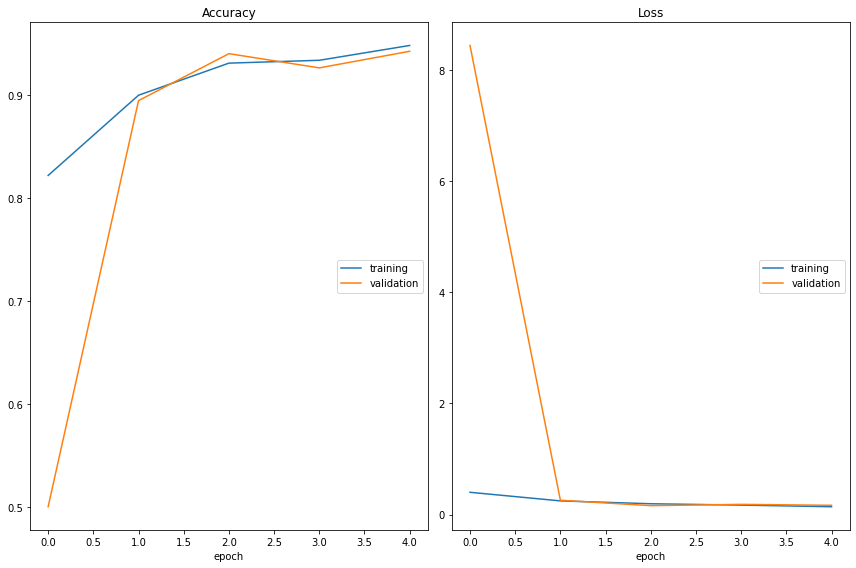

Accuracy
	training         	 (min:    0.822, max:    0.948, cur:    0.948)
	validation       	 (min:    0.500, max:    0.943, cur:    0.943)
Loss
	training         	 (min:    0.142, max:    0.402, cur:    0.142)
	validation       	 (min:    0.161, max:    8.437, cur:    0.168)
Epoch 00005: early stopping


In [ ]:
from livelossplot import PlotLossesKerasTF
import os
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',mode='min',
                                      verbose = 2, patience=2)

trainer=model.fit(train_generator,validation_data=validation_generator,
                  epochs=30,
                  callbacks = [cp_callback,es,PlotLossesKerasTF()])

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)
probabilities = model.predict_generator(generator=validation_generator)
y_true = validation_generator.classes
y_pred = probabilities > 0.5

from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[566 518]
 [548 536]]


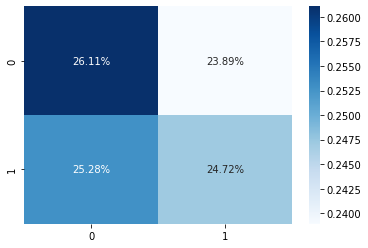

In [ ]:
import seaborn as sns
import numpy as np

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.51      0.52      0.52      1084
           1       0.51      0.49      0.50      1084

    accuracy                           0.51      2168
   macro avg       0.51      0.51      0.51      2168
weighted avg       0.51      0.51      0.51      2168



Normal 0.95720786


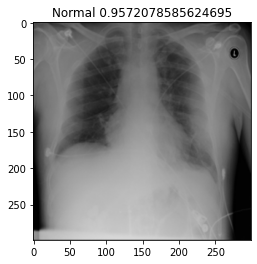

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

def GetResult(img_path):
  img = cv.imread(img_path)
  plt.imshow(img)
  

  img = image.load_img(img_path, target_size=(256, 256),color_mode="grayscale")
  img_array = image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)
  prediction = model.predict(img_batch)
  
  if prediction>0.5:
    print("Normal",prediction[0][0])
    plt.title(f"Normal {prediction[0][0]}")
  else:
    print("Covid",1-prediction[0][0])
    plt.title(f"Covid {1-prediction[0][0]}")
  plt.show()
img_path = "/content/COVID-19_Radiography_Dataset/Normal/images/Normal-10100.png" #@param ["/content/COVID-19_Radiography_Dataset/Normal/images/Normal-1100.png", "/content/COVID-19_Radiography_Dataset/COVID/images/COVID-1000.png"] {allow-input: true}
GetResult(img_path)